# MODS203: Data analysis in economics I: Collection and Visualization (2022-2023)


Student names: 
* Daniel Victor Ferreira da Silva
* Gabriel Martins de Andrade 
* Lucas Otávio Nascimento de Araújo

## Research question

 In this project, we collected data from physicians and their appointment options in 3 different countries (France, Germany, and Italy), using Doctolib's website, to compare different parameters and patterns between the countries. Thus, the searches for doctors were made on each site using their specialties as the basis of the search; and, from each doctor, their spoken languages, their minimum consultation price, and their availability, among other data, were collected. With the data collected 3 topics will be addressed and analyzed.

  First, an analysis will be made of the frequency of availability of languages spoken in various specialties, and compare this data with French immigration data. It is expected to be more difficult to get appointments when not speaking French. Also, languages with a smaller speaking community would have more difficulty finding specialists in specific subjects when compared to more general and common specialty doctors. These hypotheses will be tested to answer whether an immigrant would find it easy to find medical services when moving to France. Finally, a comparison will be made between the payment methods between the countries. Then, these differences will be observed and discussed in how they affect and represent the health care system.


 Then, a prediction will be made for the minimum price and waiting time for consultation based on languages, payment method, accessibility, and the other variable not being used (for predicting waiting time we will use price as an independent variable and vice-versa). In this way, an analysis will be done to answer whether such a prediction is accurate and represents a good model for the data. Furthermore, it will be possible to see how each variable influences the final predictions, and what conclusions can be drawn from this.

## Data Description

 Each unit collected corresponds to information about a particular physician, where we collect data related to their website id, speciality (as the name of the csv's), minimum fee, position (latitude and longitude) of the appointment, availability for appointments, if the physician provides remote consultations (telehealth), the languages the doctor speaks, data about payment methods (cash, card and check), if the doctor do home visits and about acessibilty/handicap support. Below is a piece of code where it is possible to check all columns present on each csv.

In [ ]:
!pip install linearmodels
!pip install pystout
!pip install --upgrade pandas

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
import re
import datetime
import matplotlib.pyplot as plt
import os
import sys
import statsmodels.formula.api as smf
import linearmodels as ln
from pystout import pystout
from statsmodels.iolib.summary2 import summary_col
import seaborn as sns
import warnings
import folium

In [ ]:
df = pd.read_csv('Results/chiropratico_it_proc.csv')
df.columns

We chose the specialties by dividing them into 3 groups: general/common specialties (general practitioner, orthopedist...), specific specialties (nuclear medicine, sports medicine...), and alternative specialties (linked to alternative medicine, such as homeopathy). The general specialties were chosen taking into reference the division made on the French Doctolib site, in which the most common specialties were listed by the site itself, and are listed first. The other specialties are self-declared, so they have categories that are, for example, empty and have only had 1 doctor in their history.

The specialties that were chosen should be present in all 3 countries. Thus, all valid general specialties were collected, as well as 4 more specific specialties and 3 alternative medicine specialties. Below is a screenshot to better understand how the specialties were separated. Unfortunately for France, the specialties of general doctor, dentist, psychologist, and osteopath were not collected, because they presented too much data and were left last. Moreover, there was probably an update of the Doctolib site that did not allow the collection of more than 20 data at once, which made the collection impossible.

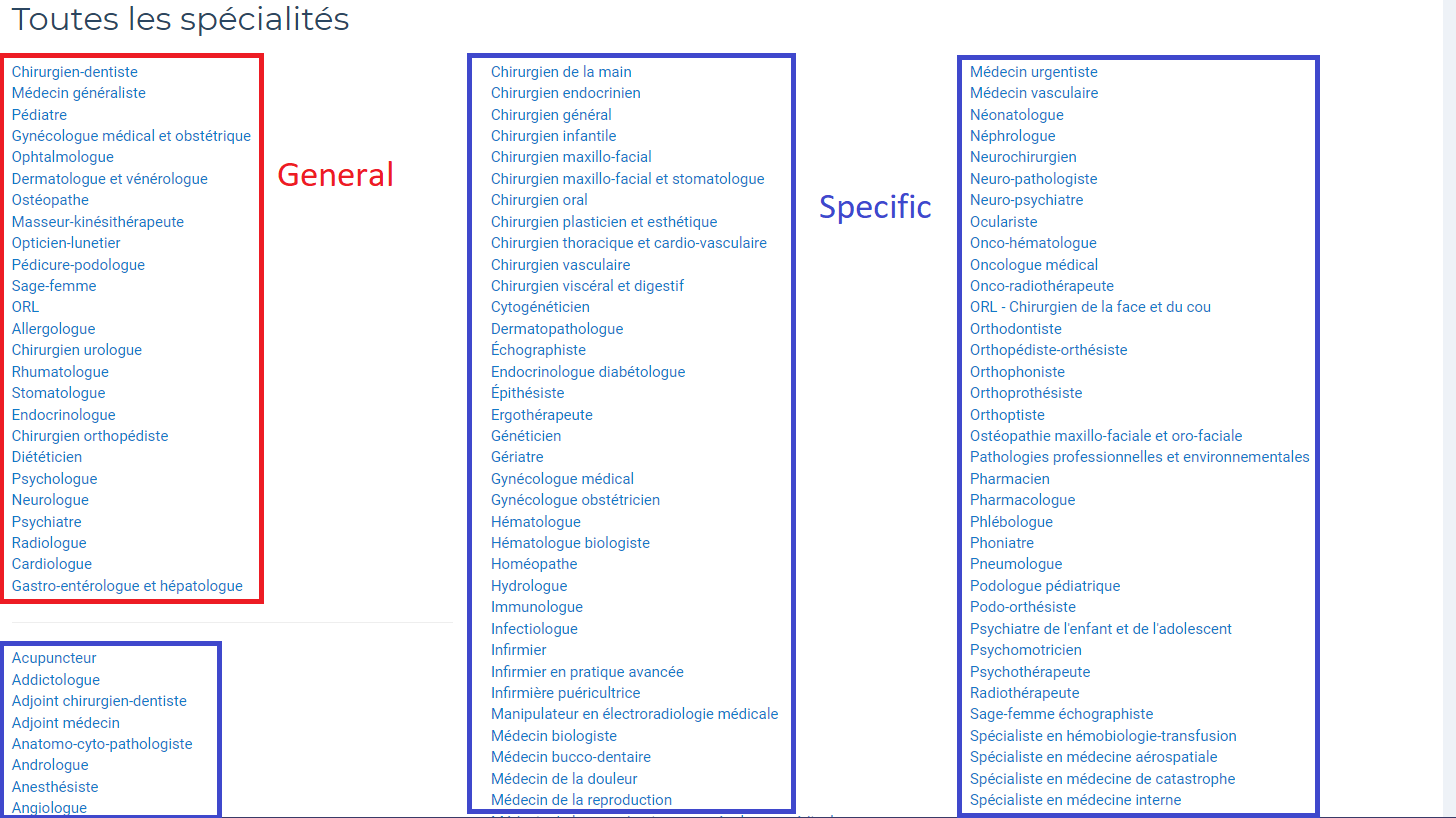

From the collected data, a new column called 'wait' was created, which returns the waiting time to see the doctor, which was not available in the original data, but can be inferred, since the next available date was collected.

In [ ]:
def wait(df):
  date = 0
  for avail in df.avail:
      if not pd.isna(avail):
          if avail[0] == "[":
              date = re.findall(r"[0-9-]+",avail)[0]
              date = pd.to_datetime(date)
              break
  wait = []
  for avail in df.avail:
      if pd.isna(avail):
          wait.append(None)
          continue
      elif avail[0] == "[":
          slot = re.findall(r"[0-9-:]+T[0-9-:+.]+",avail)[0]
          slot = pd.to_datetime(slot).replace(tzinfo=None)
          wait.append((slot-date).days)
      else:
          slot = pd.to_datetime(avail).replace(tzinfo=None)
          wait.append((slot-date).days)
  df["wait"] = wait
  df.wait.fillna(df.wait.max()+10, inplace=True)
  return df

The specialities are divided into their categories bellow:

In [ ]:
#List of each specialty division
out_fr = ["dentiste", "medecin-generaliste","osteopathe","psychologue"] #data left out
gen_fr = ["pediatre","gynecologue", "ophtalmologue", "dermatologue",  "pedicure-podologue", "sage-femme", "orl-oto-rhino-laryngologie", "chirurgien-urologue", "rhumatologue", "endocrinologue", "chirurgien-orthopediste", "dieteticien",  "neurologue", "psychiatre", "radiologue", "cardiologue", "gastro-enterologue",'chirurgien-plastique','chirurgien']
spe_fr = ['homeopathe','acupuncteur','chiropracteur']
alt_fr = ['medecin-du-sport','pneumologue','medecine-nucleaire','geriatre','hematologue']
gen_it = ["odontoiatra", "medico-di-medicina-generale", 'pediatra','ginecologo-ostetrico','oftalmologo','dermatologo-venereologo','osteopata','podologo','ostetrico','otorinolaringoiatra','urologo','reumatologo','endocrinologo','ortopedico-traumatologo','nutrizionista','psicologo','neurologo','psichiatra','radiologo-diagnostico','cardiologo','gastroenterologo','chirurgo-plastico','chirurgo-generale']
spe_it = ['omeopata','agopuntore','chiropratico']
alt_it = ['medico-dello-sport','pneumologo','medico-nucleare','geriatra','ematologo']
gen_de = ["prophylaxeassistentin", "allgemeinmedizin",'kinderheilkunde-kinder-und-jugendmedizin','frauenarzt','augenheilkunde','hautarzt','osteopath','podologe-fusspflege','hebamme','facharzt-fur-hno','urologie','rheumatologie','endokrinologe','orthopadie','diatassistent','psychologischer-psychotherapeut-psychotherapeutin','neurologie','psychiatrie-und-psychotherapie','radiologe','kardiologie','gastroenterologie','plastische-und-asthetische-chirurgie','allgemeiner-chirurg']
spe_de = ['homoopathie','akupunktur','chiropraktik']
alt_de = ['sportwissenschaftler','pneumologe','nuklearmedizin','geriater','hamatologe-onkologe']

#reference df
df = pd.read_csv('pediatre_fr_proc.csv')

#Read the french data
df_gen_fr = df[df["id"]==1].copy()
for i in gen_fr:
  df2 = pd.read_csv(i+'_fr'+'_proc'+'.csv')
  df_gen_fr = df_gen_fr.append(df2)

df_spe_fr = df[df["id"]==1].copy()
for i in spe_fr:
  df2 = pd.read_csv(i+'_fr'+'_proc'+'.csv')
  df_spe_fr = df_spe_fr.append(df2)

df_alt_fr = df[df["id"]==1].copy()
for i in alt_fr:
  df2 = pd.read_csv(i+'_fr'+'_proc'+'.csv')
  df_alt_fr = df_alt_fr.append(df2)

#Read the italian data
df_gen_it = df[df["id"]==1].copy()
for i in gen_it:
  df2 = pd.read_csv(i+'_it'+'_proc'+'.csv')
  df_gen_it = df_gen_it.append(df2)

df_spe_it = df[df["id"]==1].copy()
for i in spe_it:
  df2 = pd.read_csv(i+'_it'+'_proc'+'.csv')
  df_spe_it = df_spe_it.append(df2)

df_alt_it = df[df["id"]==1].copy()
for i in alt_it:
  df2 = pd.read_csv(i+'_it'+'_proc'+'.csv')
  df_alt_it = df_alt_it.append(df2)

#Read the german data
df_gen_de = df[df["id"]==1].copy()
for i in gen_de:
  df2 = pd.read_csv(i+'_de'+'_proc'+'.csv')
  df_gen_de = df_gen_de.append(df2)

df_spe_de = df[df["id"]==1].copy()
for i in spe_de:
  df2 = pd.read_csv(i+'_de'+'_proc'+'.csv')
  df_spe_de = df_spe_de.append(df2)

df_alt_de = df[df["id"]==1].copy()
for i in alt_de:
  df2 = pd.read_csv(i+'_de'+'_proc'+'.csv')
  df_alt_de = df_alt_de.append(df2)

#Apply the wait function
df_spe_fr = wait(df_spe_fr)
df_gen_fr = wait(df_gen_fr)
df_alt_fr = wait(df_alt_fr)

df_spe_it = wait(df_spe_it)
df_gen_it = wait(df_gen_it)
df_alt_it = wait(df_alt_it)

df_spe_de = wait(df_spe_de)
df_gen_de = wait(df_gen_de)
df_alt_de = wait(df_alt_de)

In [ ]:
#First measure the lenght of each country, then sum them
len_fr = len(df_gen_fr)+len(df_alt_fr)+len(df_spe_fr)
print('Number of data units collected in France =',len_fr)
len_it = len(df_gen_it)+len(df_alt_it)+len(df_spe_it)
print('Number of data units collected in Italy =',len_it)
len_de = len(df_gen_de)+len(df_alt_de)+len(df_spe_de)
print('Number of data units collected in Germany =',len_de)
print('Total number of units of observation =',len_fr+len_it+len_de)

Number of data units collected in France = 46539
Number of data units collected in Italy = 9383
Number of data units collected in Germany = 15869
Total number of units of observation = 71791


## Visualization and Correlations

### Waiting Time

In [ ]:
# Lists of countries and categories of specialties
cts = ["it", "de", "fr"]
cats = ["gen","spe","alt"]

# Initialization of waiting lists that store waiting times according to country and category
waiting = {(ct,cat):[] for ct in ["it", "de", "fr"] for cat in ["gen","spe","alt"]} 
for ct in cts:
    waiting[ct] = []


for ct in ["it", "de", "fr"]:
    # Defines which are the specialties according to the country
    if ct=="fr":
        gen_ = gen_fr
        spe_ = spe_fr
        alt_ = alt_fr
    elif ct=="de":
        gen_ = gen_de
        spe_ = spe_de
        alt_ = alt_de
    elif ct=="it":
        gen_ = gen_it
        spe_ = spe_it
        alt_ = alt_it
    path =  r"Results/"
    for root, dirs, files in os.walk(path):
        for filename in files:
            if filename[-11:] == ct+'_proc.csv':
                df = pd.read_csv(path+filename)
                spec = filename.split('_')[0]

                # Calculates waiting time
                date = 0
                for avail in df.avail:
                    if not pd.isna(avail):
                        if avail[0] == "[":
                            date = re.findall(r"[0-9-]+",avail)[0]
                            date = pd.to_datetime(date)
                            break
                wait = []
                for avail in df.avail:
                    if pd.isna(avail):
                        wait.append(None)
                        continue
                    elif avail[0] == "[":
                        slot = re.findall(r"[0-9-:]+T[0-9-:+.]+",avail)[0]
                        slot = pd.to_datetime(slot).replace(tzinfo=None)
                        wait.append((slot-date).days)
                    else:
                        slot = pd.to_datetime(avail).replace(tzinfo=None)
                        wait.append((slot-date).days)
                df["wait"] = wait

                # Treats null cases
                df.wait.fillna(500, inplace=True)
                waiting[ct] += list(df['wait'].values)
                if filename[:-12] in gen_:
                    waiting[(ct,'gen')] += list(df['wait'].values)
                elif filename[:-12] in spe_:
                    waiting[(ct,'spe')] += list(df['wait'].values)
                elif filename[:-12] in alt_:
                    waiting[(ct,'alt')] += list(df['wait'].values)

                

# Numpifies waiting time lists
for key in waiting.keys():
    waiting[key] = np.array(waiting[key])

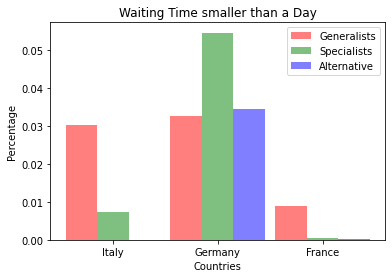

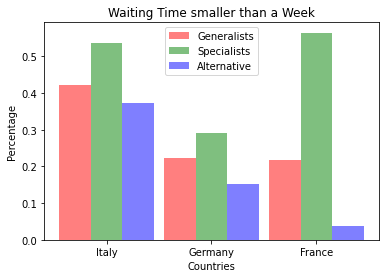

[0.25217784817287026, 0.324326292789512, 0.3846660165772794] [0.17647058823529413, 0.2339579784213515, 0.12290502793296089] [0.2181372549019608, 0.328042328042328, 0.7341520079654829]


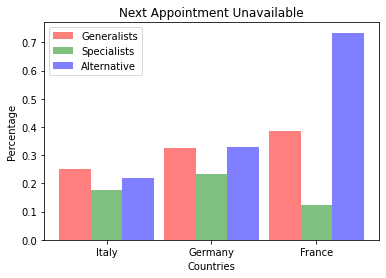

In [ ]:
countries = ["Italy", "Germany", "France"]

# Calculates incidence of waiting less than a day
gen_inc = [len(waiting[(ct,"gen")][waiting[(ct,"gen")] < 1])/len(waiting[(ct,"gen")]) for ct in cts]
spe_inc = [len(waiting[(ct,"spe")][waiting[(ct,"spe")] < 1])/len(waiting[(ct,"spe")]) for ct in cts]
alt_inc = [len(waiting[(ct,"alt")][waiting[(ct,"alt")] < 1])/len(waiting[(ct,"alt")]) for ct in cts]

X_axis = np.arange(len(countries))
plt.bar(X_axis - 0.3, gen_inc, 0.3, label = 'Generalists', color='r', alpha=0.5)
plt.bar(X_axis, spe_inc, 0.3, label = 'Specialists', color='g', alpha=0.5)
plt.bar(X_axis + 0.3, alt_inc, 0.3, label = 'Alternative', color='b', alpha=0.5)
plt.xticks(X_axis, countries)

plt.grid(False)
plt.xlabel("Countries")
plt.ylabel("Percentage")
plt.title("Waiting Time smaller than a Day")
plt.legend()
plt.show()

# Calculates incidence of waiting less than a week
gen_inc = [len(waiting[(ct,"gen")][waiting[(ct,"gen")] < 7])/len(waiting[(ct,"gen")]) for ct in cts]
spe_inc = [len(waiting[(ct,"spe")][waiting[(ct,"spe")] < 7])/len(waiting[(ct,"spe")]) for ct in cts]
alt_inc = [len(waiting[(ct,"alt")][waiting[(ct,"alt")] < 7])/len(waiting[(ct,"alt")]) for ct in cts]

X_axis = np.arange(len(countries))
plt.bar(X_axis - 0.3, gen_inc, 0.3, label = 'Generalists', color='r', alpha=0.5)
plt.bar(X_axis, spe_inc, 0.3, label = 'Specialists', color='g', alpha=0.5)
plt.bar(X_axis + 0.3, alt_inc, 0.3, label = 'Alternative', color='b', alpha=0.5)
plt.xticks(X_axis, countries)

plt.grid(False)
plt.xlabel("Countries")
plt.ylabel("Percentage")
plt.title("Waiting Time smaller than a Week")
plt.legend()
plt.show()

# Calculates incidence of appointments without a time
gen_inc = [len(waiting[(ct,"gen")][waiting[(ct,"gen")] == 500])/len(waiting[(ct,"gen")]) for ct in cts]
spe_inc = [len(waiting[(ct,"spe")][waiting[(ct,"spe")] == 500])/len(waiting[(ct,"spe")]) for ct in cts]
alt_inc = [len(waiting[(ct,"alt")][waiting[(ct,"alt")] == 500])/len(waiting[(ct,"alt")]) for ct in cts]

X_axis = np.arange(len(countries))
plt.bar(X_axis - 0.3, gen_inc, 0.3, label = 'Generalists', color='r', alpha=0.5)
plt.bar(X_axis, spe_inc, 0.3, label = 'Specialists', color='g', alpha=0.5)
plt.bar(X_axis + 0.3, alt_inc, 0.3, label = 'Alternative', color='b', alpha=0.5)
plt.xticks(X_axis, countries)

plt.grid(False)
plt.xlabel("Countries")
plt.ylabel("Percentage")
plt.title("Next Appointment Unavailable")
plt.legend()
plt.show()

From the first graph, we noticed that Germany is the easiest country to set up an urgent appointment: from 3% to 5% of doctors would be available there, which is superior to Italy's and France's percentages. In Italy, it would be possible to find a general doctor available (3%), very unlikely to find a specialist (less than 1%), and nearly impossible to get an alternative medicine appointment. France presents the worse of the 3 scenarios: its probabilities are less than 1% for general physicians and almost zero for the other two.


In the intermediate time stamp, Italy leaps: more than half its specialists can be consulted in less than a week and other categories are close to 40%. In Germany, the availability presents intermediate values, from 15% to 30%. In France, the difference between categories intensifies as more than 50% of specialists are available but only 4% of alternative medicine professionals. Also, it is worth highlighting that, in all countries, specialists are more available than generalists, who are more so than alternatives. It might indicate that citizens from these nations usually follow the recommendation to go to a general physician before searching for a more specific doctor, reducing the charge on specialists.


In Italy and Germany, a considerable amount of doctors offer no appointments, and the scenario is better in the first (from 15% to 25%) than in the second (from 20% to 35%). France is the country with the most doctors fully booked for generalists (38%) and alternative medicine practicians (a staggering 73%) and the least for specialists (12%). These results reinforce the thesis of a smaller charge on specialists for France and show evidence of the high demand for alternative medicine in the country. The group created a hypothesis that the value of 73% percent could have resulted from the combination of the lasting trend of alternative medicine in France [1] and its somewhat recent coverage interruption by the national health system. [2]

### Payment Methods' Analysis

In [ ]:
import os
import matplotlib.pyplot as plt

# Calculates the acceptance of each payment method according to country and specialty
cash = dict()
card = dict()
check = dict()
for ct in ["it", "de", "fr"]:
    path =  r"Results/"
    for root, dirs, files in os.walk(path):
        for filename in files:
            if filename[-11:] == ct+'_proc.csv':
                df = pd.read_csv(path+filename)
                spec = filename.split('_')[0]
                cash[spec] = (df.accept_cash.mean(), len(df.accept_cash))
                card[spec] = (df.accept_credit_card.mean(), len(df.accept_credit_card))
                check[spec] = (df.accept_check.mean(), len(df.accept_check))

specs_fr = ["pediatre", "gynecologue", "ophtalmologue", "dermatologue", "pedicure-podologue", "sage-femme", "orl-oto-rhino-laryngologie", "chirurgien-urologue", "rhumatologue", "endocrinologue", "chirurgien-orthopediste", "dieteticien", "neurologue", "psychiatre", "radiologue", "cardiologue", "gastro-enterologue",'chirurgien-plastique','acupuncteur','chiropracteur','geriatre','hematologue','homeopathe','medecin-du-sport','pneumologue','medecine-nucleaire','chirurgien']
specs_it = ["odontoiatra", "medico-di-medicina-generale", 'pediatra','ginecologo-ostetrico','oftalmologo','dermatologo-venereologo','osteopata','podologo','ostetrico','otorinolaringoiatra','urologo','reumatologo','endocrinologo','ortopedico-traumatologo','nutrizionista','psicologo','neurologo','psichiatra','radiologo-diagnostico','cardiologo','gastroenterologo','chirurgo-plastico','agopuntore','chiropratico','geriatra','ematologo','omeopata','medico-dello-sport','pneumologo','medico-nucleare','chirurgo-generale']
specs_de = ["prophylaxeassistentin", "allgemeinmedizin",'kinderheilkunde-kinder-und-jugendmedizin','frauenarzt','augenheilkunde','hautarzt','osteopath','podologe-fusspflege','hebamme','facharzt-fur-hno','urologie','rheumatologie','endokrinologe','orthopadie','diatassistent','psychologischer-psychotherapeut-psychotherapeutin','neurologie','psychiatrie-und-psychotherapie','radiologe','kardiologie','gastroenterologie','plastische-und-asthetische-chirurgie','akupunktur','chiropraktik','geriater','hamatologe-onkologe','homoopathie','sportwissenschaftler','pneumologe','nuklearmedizin','allgemeiner-chirurg']

specs = {"fr": specs_fr, "it": specs_it, "de": specs_de}

In [ ]:
# Performs a pondered mean to calculate the acceptance of each payment method by country
for ct in ['fr', 'de', 'it']:

    den = 0
    num_card = 0
    num_cash = 0
    num_check = 0

    for spec in specs[ct]:
        num_card += card[spec][0]*card[spec][1]
        num_cash += cash[spec][0]*cash[spec][1]
        num_check += check[spec][0]*check[spec][1]
        den += card[spec][1]

    card[ct] = num_card / den
    cash[ct] = num_cash / den
    check[ct] = num_check / den

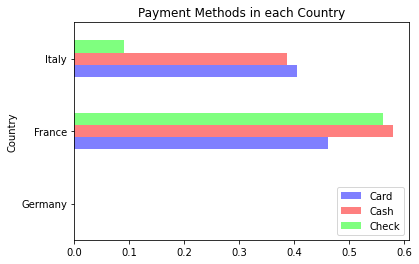

In [ ]:
alpha = 0.5

card_se = pd.Series([card[s] for s in ['de','it','fr']],['de','it','fr'])
methods = pd.DataFrame({"Country":card_se.keys(), "type":['Card']*len(card_se), "value":card_se.values})

cash_se = pd.Series([cash[s] for s in ['de','it','fr']],['de','it','fr'])
methods = methods.append(pd.DataFrame({"Country":cash_se.keys(), "type":['Cash']*len(cash_se), "value":cash_se.values}))

check_se = pd.Series([check[s] for s in ['de','it','fr']],['de','it','fr'])
methods = methods.append(pd.DataFrame({"Country":check_se.keys(), "type":['Check']*len(check_se), "value":check_se.values}))

methods = methods.set_index(['Country', 'type']).value
methods = methods.sort_index(ascending=True)
methods.unstack().plot(kind='barh', stacked=False, alpha=0.5, colormap='brg')
#card_se = card_se.set_index(['Languages', 'type']).value

ticks, labels = plt.yticks()
plt.yticks(ticks,["Germany", "France", "Italy"])

plt.legend(loc="lower right")
plt.title("Payment Methods in each Country")
plt.grid(False)

plt.savefig("PaymentMethods.png",dpi=500)
plt.show()

In Italy, the most used payment method is credit card, followed closely by cash. In last, it is check, and accepted by only 10% of doctors. In France, most professionals accept cash and check, and many take credit cards as well. This variation points out a cultural difference between those countries: the usage of the check is still strong in french society, while it has been in decline in many countries.

In Germany's healthcare system, patients don't pay at the point of service. This is the reason why no German doctor in Doctolib includes payment methods.

### Languages' accessibility

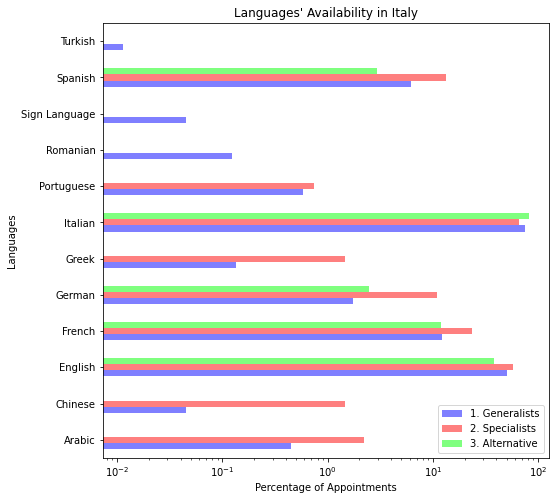

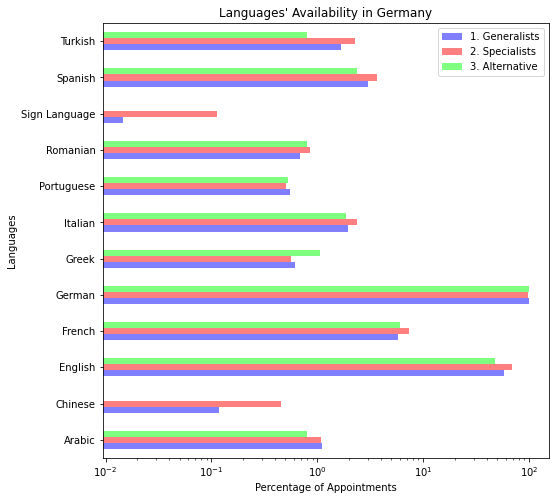

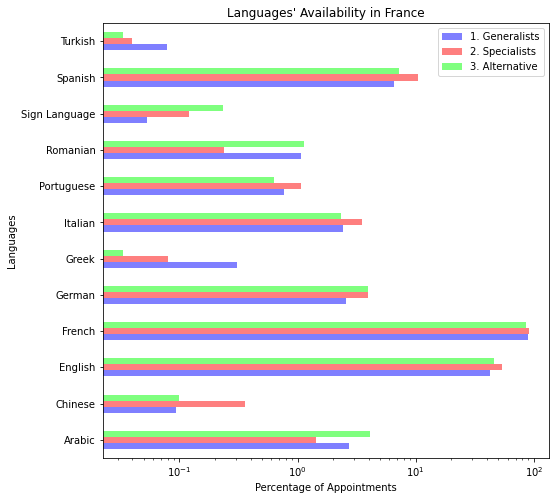

In [ ]:
# Counts the appearances of each language
for ct in ["it", "de", "fr"]:
    if ct=="fr":
        gen_ = gen_fr
        spe_ = spe_fr
        alt_ = alt_fr
    elif ct=="de":
        gen_ = gen_de
        spe_ = spe_de
        alt_ = alt_de
    elif ct=="it":
        gen_ = gen_it
        spe_ = spe_it
        alt_ = alt_it
    # Languages the Most present in the Dataset
    languages = ['English', 
        'French', 'Italian', 'German', 'Spanish', 'Portuguese','Romanian', 
        'Arabic','Turkish', 'Greek', 'Chinese','Sign Language']
    lang_gen = dict(zip(languages, np.zeros(len(languages))))
    lang_spe = dict(zip(languages, np.zeros(len(languages))))
    lang_alt = dict(zip(languages, np.zeros(len(languages))))
    tot_gen = 0
    tot_spe = 0
    tot_alt = 0
    for root, dirs, files in os.walk(path):
        for filename in files:
            df = pd.read_csv(path+filename)
            df['Sign Language'] = df['French Sign Language']
            if filename[:-12] in gen_:    
                if filename[-11:] == ct+'_proc.csv':
                    for l in languages:
                        lang_gen[l] += df[l].sum()
                    tot_gen += len(df)
            elif filename[:-12] in spe_:
                if filename[-11:] == ct+'_proc.csv':
                    for l in languages:
                        lang_spe[l] += df[l].sum()
                    tot_spe += len(df)
            elif filename[:-12] in alt_:
                if filename[-11:] == ct+'_proc.csv':
                    for l in languages:
                        lang_alt[l] += df[l].sum()
                    tot_alt += len(df)
    
    # Calculates the percentage of each language
    factor = 100
    for l in languages:
        lang_gen[l] /= tot_gen / factor
        lang_spe[l] /= tot_spe / factor
        lang_alt[l] /= tot_alt / factor
    

    ln = pd.Series(lang_gen)
    ln_type = pd.Series(['1. Generalists']*len(ln))
    ln_tot = pd.DataFrame({"Languages":ln.keys(), "type":ln_type, "value":ln.values})

    ln = pd.Series(lang_spe)
    ln_type = pd.Series(['2. Specialists']*len(ln))
    ln_tot = ln_tot.append(pd.DataFrame({"Languages":ln.keys(), "type":ln_type, "value":ln.values}))

    ln = pd.Series(lang_alt)
    ln_type = pd.Series(['3. Alternative']*len(ln))
    ln_tot = ln_tot.append(pd.DataFrame({"Languages":ln.keys(), "type":ln_type, "value":ln.values}))

    ln_tot = ln_tot.set_index(['Languages', 'type']).value
    ln_tot = ln_tot.sort_index(ascending=True)

    ln_tot.unstack().plot(kind='barh', log=True, stacked=False, alpha=0.5, colormap='brg', figsize=(8,8))

    plt.title("Languages' Availability in {}".format("Italy" if ct == 'it' else "Germany" if ct == "de" else "France"))
    plt.xlabel("Percentage of Appointments")
    plt.grid(False)
    plt.legend()
    plt.savefig("LanguagesGenSpeAlt_{}.png".format(ct),dpi=500)
    plt.show()
    print()

In all graphs, we will have the native language of the country with percentages close to 100%, since it is mandatory for every country that the doctor speaks the local language to be registered in the medicine council. Therefore, in the analysis we will ignore the native language of each country. Besides, the graphs are displayed in percentage, so the fact of having more or less samples from a certain country will not be very relevant, since everything has been done in relation to the number of total samples. 

From the graph of Italy, we can observe that the most expressive language is English, followed by French, Spanish and then German. Regarding the medical categories, we observe that there is a relative balance for all these most expressive languages, except for German, where the number of more specialized doctors is higher. From the reference [3], we have that the 2 largest groups of foreign citizens living in Italy are, respectively, Romanian and Moroccan. If we look at the data for Romanian speaking doctors, the number is very small, around 0.1%. For doctors who speak Arabic (as the representation of the Berber language was inexpressive, it was not inserted in the graph, however, Arabic is also an official language of Morocco) we have on average 1% of the doctors, which is an expressive number considering the proportional number of immigrants in the country. These, however, do not offer alternative medicine options, which in itself is not a serious problem, given that such specialties are not seen as essential in a health care system. 

From the German graph, we can observe that the most expressive language is English, followed by French, Spanish and then Turkish, tied with Italian. Regarding the medical categories, we observe that there is a balance for all the most expressive languages. From reference [4] we have that the 2 largest groups of foreign citizens residing in Germany are respectively Turkish and Polish. If we observe the data for Turkish speaking doctors, we have a significant number, greater than 1%, which represents that a newly immigrated Turkish people would find doctors who speak his language. For Polish people, however, there is not a significant number of doctors who speak the language, making it difficult for this migratory group to access health care. 

From the graph of France, we can observe that the most expressive language is English, followed by Spanish, Arabic tied with Italian and finally Portuguese. Regarding the medical categories, we observe that there is a balance for all the most expressive languages. From the reference [5] we have that the 2 largest groups of foreign citizens migrating to France (the reference is from 2013, however, it is the most recent dataset available) are, respectively, Portuguese and Moroccan/Algerian tied. If we look at the data for Portuguese speaking doctors, we have an expressive number, around 1%, which should be enough to supply the number of immigrants. For the Moroccans and Algerians, we will take the language spoken by them as Arabic, for the same reason cited above. Arabic has a representation of more than 2%, which should also supply the demand for immigrants. 

 From the analysis, we concluded that France presents the health care system the most linguistically receptive for its largest immigrant groups, taking into account only their native languages. Also, it is important to highlight that English is the most represented language (other than national one) for the three countries. As it is nowadays the most spoken language in the world, it acts as a possible option for an immigrant who cannot find a doctor in his/her native language. Another intersting point is the representation of the Greek language in the 3 countries, which is an ethnic group not very present in the countries, but that are overrepresented in terms of language. Another point to comment on is that throughout this analysis we talk about magnitudes of 1 or 2%, which may seem small, but immigrant groups hardly represent more than 0.5% of the country. 

### Correlation Analysis

In [ ]:
def agg_df(ct, path="/content/Results/"):
  df_g = pd.DataFrame(columns=['id','minimum_fee', 'telehealth',
       'avail', 'English', 'Spanish', 'Italian', 'German', 'Portuguese',
       'Japanese', 'Chinese', 'Arabic', 'Hebrew', 'Swedish', 'Korean',
       'Persian', 'Romanian', 'Polish', 'Russian', 'Greek', 'Kabyle', 'Berber',
       'Hungarian', 'Catalan', 'Dutch', 'Iranian', 'Armenian', 'Vietnamite',
       'French', 'Turkish', 'Kurdish', 'Czech', 'Ukrainien', 'Slovak',
       'Bulgarian', 'French Sign Language', 'accept_check', 'accept_cash',
       'accept_credit_card', 'home_visit', 'avail_this_week',
       'avail_next_week', 'accessible', 'handicap'])
  specs = []
  for root, dirs, files in os.walk(path):
      for filename in files:
          if filename[-11:] == ct+'_proc.csv' or ct == 'total':
              df = pd.read_csv(path+filename)
              date = 0
              for avail in df.avail:
                  if not pd.isna(avail):
                      if avail[0] == "[":
                          date = re.findall(r"[0-9-]+",avail)[0]
                          date = pd.to_datetime(date)
                          break
              wait = []
              for avail in df.avail:
                  if pd.isna(avail):
                      wait.append(None)
                      continue
                  elif avail[0] == "[":
                      slot = re.findall(r"[0-9-:]+T[0-9-:+.]+",avail)[0]
                      slot = pd.to_datetime(slot).replace(tzinfo=None)
                      wait.append((slot-date).days)
                  else:
                      slot = pd.to_datetime(avail).replace(tzinfo=None)
                      wait.append((slot-date).days)
              # Compute waiting time
              df["wait"] = wait
              # Filling lacikng data in columns wait and minimum_fee
              df.wait.fillna(df.wait.max()+10, inplace=True)
              df.minimum_fee.fillna(df.minimum_fee.median(), inplace=True)
              specs+=[filename[:-12]]*df.shape[0]
              df_g = df_g.append(df)
  # Add column specialty
  df_g["spec"] = specs
  df_g["SL"] = df_g["French Sign Language"]
  return  df_g

<ipython-input-6-dcb3fb7b5b40>:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  corr = df_.drop(df_.sum(0).index[df_.sum(0)==0], 1).corr(numeric_only=False)


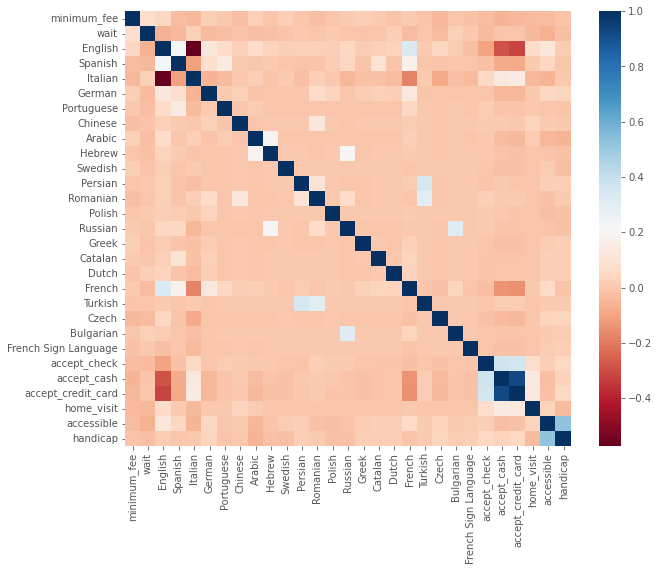

<ipython-input-6-dcb3fb7b5b40>:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  corr = df_.drop(df_.sum(0).index[df_.sum(0)==0], 1).corr(numeric_only=False)


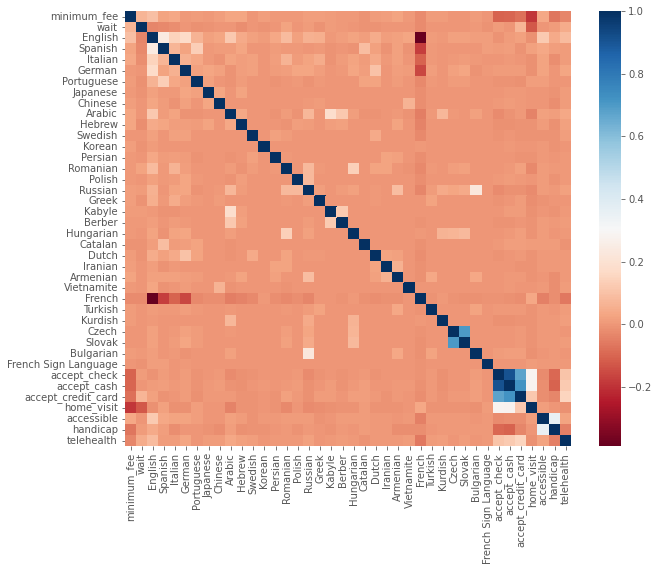

<ipython-input-6-dcb3fb7b5b40>:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  corr = df_.drop(df_.sum(0).index[df_.sum(0)==0], 1).corr(numeric_only=False)


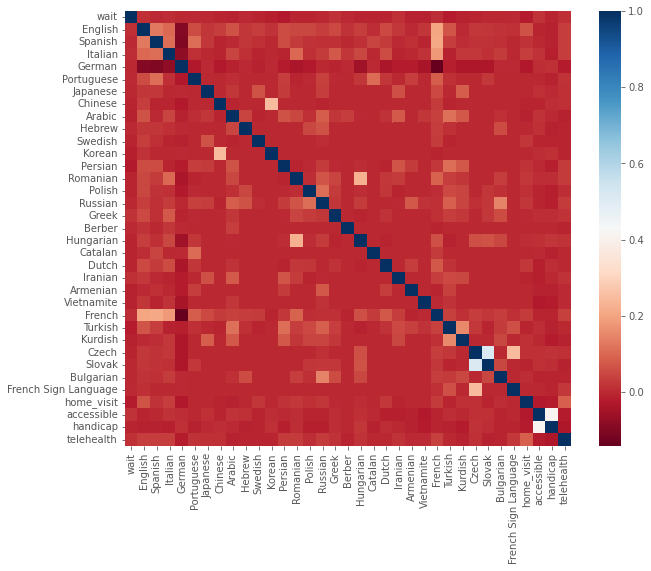

In [ ]:
cols = ['minimum_fee', 'wait', 'English', 'Spanish', 'Italian',
       'German', 'Portuguese', 'Japanese', 'Chinese', 'Arabic', 'Hebrew',
       'Swedish', 'Korean', 'Persian', 'Romanian', 'Polish', 'Russian',
       'Greek', 'Kabyle', 'Berber', 'Hungarian', 'Catalan', 'Dutch', 'Iranian',
       'Armenian', 'Vietnamite', 'French', 'Turkish', 'Kurdish', 'Czech',
       'Ukrainien', 'Slovak', 'Bulgarian', 'French Sign Language',
       'accept_check', 'accept_cash', 'accept_credit_card', 'home_visit', 
       'accessible', 'handicap','telehealth']

dfs = dict() 
for ct in ['it', 'fr', 'de', 'total']:
  df_g =0
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_g = agg_df(ct)
  dfs[ct] = df_g

for ct in ['it', 'fr', 'de']:
  # calculate the correlation matrix
  fig, ax = plt.subplots(figsize=(10,8)) 
  df_ = dfs[ct][cols]
  corr = df_.drop(df_.sum(0).index[df_.sum(0)==0], 1).corr(numeric_only=False)

  # plot the correlation heatmap
  sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu', ax=ax)
  plt.show()

In a analysis of correlation between the variables previous to the regression, we can observe that despite only 3 groups of variables that present some sort of correlation, the czech and slovak languages, accessible and handicap, and the payment methods, most variables are not correlated.

## Regression Analysis

Other question that we want to answer is "Can we predict the waiting time for an appoitment based on the other variables collected?". That way, we try to analyse through a Linear Regression how well we can predict the waiting time as a dependable variable of the minimum price, payment methods, languages accepted, specialization and accessibilities informations. Besides this analysis, we also performed another regression using the minimum price as the dependable variable of the others variables.

As already descripted in previous section, the waiting time and minimum price are numeric variables, while the before categorical variables of languages, payment methods, specialties and accessibility are booleans.

Therefore, the models were structured in the following way: The search results of specialties are aggregated for each country, to increase the sample size for the regression, and two models for each dependable variables are created, the first with all the variables except languages, and the second with them included, in that way, we can also analyse the impact of the languages of the accepted languages for the appointment influences our two predicted variables.

In [ ]:
ct = 'it'
model1 = smf.ols(formula='''wait ~ minimum_fee + accept_check + accept_cash
 + accept_credit_card + accessible + handicap + telehealth + home_visit + spec
  ''', data=dfs[ct]).fit()

model2 = smf.ols(formula='''wait ~ minimum_fee + accept_check + accept_cash
 + accept_credit_card + accessible + handicap + telehealth + home_visit +
 English + Spanish + Italian + German + Portuguese + 
 Japanese + Chinese + Arabic + Hebrew + Swedish + Korean + 
 Persian + Romanian + Polish + Russian + Greek + Kabyle + Berber + 
 Hungarian + Catalan + Dutch + Iranian + Armenian + Vietnamite + 
 French + Turkish + Kurdish + Czech + Ukrainien + Slovak + 
 Bulgarian + SL + spec''', data=dfs[ct]).fit()

model3 = smf.ols(formula='''minimum_fee ~ wait + accept_check + accept_cash
 + accept_credit_card + accessible + handicap + telehealth + home_visit + spec
  ''', data=dfs[ct]).fit()

model4 = smf.ols(formula='''minimum_fee ~ wait + accept_check + accept_cash
 + accept_credit_card + accessible + handicap + telehealth + home_visit +
 English + Spanish + Italian + German + Portuguese + 
 Japanese + Chinese + Arabic + Hebrew + Swedish + Korean + 
 Persian + Romanian + Polish + Russian + Greek + Kabyle + Berber + 
 Hungarian + Catalan + Dutch + Iranian + Armenian + Vietnamite + 
 French + Turkish + Kurdish + Czech + Ukrainien + Slovak + 
 Bulgarian + SL + spec''', data=dfs[ct]).fit()

In [ ]:
ct = 'fr'

model5 = smf.ols(formula='''wait ~ minimum_fee + accept_check + accept_cash
 + accept_credit_card + accessible + handicap + telehealth + home_visit + spec
  ''', data=dfs[ct]).fit()

model6 = smf.ols(formula='''wait ~ minimum_fee + accept_check + accept_cash
 + accept_credit_card + accessible + handicap + telehealth + home_visit +
 English + Spanish + Italian + German + Portuguese + 
 Japanese + Chinese + Arabic + Hebrew + Swedish + Korean + 
 Persian + Romanian + Polish + Russian + Greek + Kabyle + Berber + 
 Hungarian + Catalan + Dutch + Iranian + Armenian + Vietnamite + 
 French + Turkish + Kurdish + Czech + Ukrainien + Slovak + 
 Bulgarian + SL + spec''', data=dfs[ct]).fit()

model7 = smf.ols(formula='''minimum_fee ~ wait + accept_check + accept_cash
 + accept_credit_card + accessible + handicap + telehealth + home_visit + spec
  ''', data=dfs[ct]).fit()

model8 = smf.ols(formula='''minimum_fee ~ wait + accept_check + accept_cash
 + accept_credit_card + accessible + handicap + telehealth + home_visit +
 English + Spanish + Italian + German + Portuguese + 
 Japanese + Chinese + Arabic + Hebrew + Swedish + Korean + 
 Persian + Romanian + Polish + Russian + Greek + Kabyle + Berber + 
 Hungarian + Catalan + Dutch + Iranian + Armenian + Vietnamite + 
 French + Turkish + Kurdish + Czech + Ukrainien + Slovak + 
 Bulgarian + SL + spec''', data=dfs[ct]).fit()


In [ ]:
ct = 'de'

model9 = smf.ols(formula='''wait ~ accessible + handicap + telehealth + home_visit + spec
  ''', data=dfs[ct]).fit()

model10 = smf.ols(formula='''wait ~ accessible + handicap + telehealth + home_visit +
 English + Spanish + Italian + German + Portuguese + 
 Japanese + Chinese + Arabic + Hebrew + Swedish + Korean + 
 Persian + Romanian + Polish + Russian + Greek + Kabyle + Berber + 
 Hungarian + Catalan + Dutch + Iranian + Armenian + Vietnamite + 
 French + Turkish + Kurdish + Czech + Ukrainien + Slovak + 
 Bulgarian + SL + spec''', data=dfs[ct]).fit()

In [ ]:
ct='total'

model13 = smf.ols(formula='''wait ~ minimum_fee + accept_check + accept_cash
 + accept_credit_card + accessible + handicap + telehealth + home_visit + spec
  ''', data=dfs[ct]).fit()

model14 = smf.ols(formula='''wait ~ minimum_fee + accept_check + accept_cash
 + accept_credit_card + accessible + handicap + telehealth + home_visit +
 English + Spanish + Italian + German + Portuguese + 
 Japanese + Chinese + Arabic + Hebrew + Swedish + Korean + 
 Persian + Romanian + Polish + Russian + Greek + Kabyle + Berber + 
 Hungarian + Catalan + Dutch + Iranian + Armenian + Vietnamite + 
 French + Turkish + Kurdish + Czech + Ukrainien + Slovak + 
 Bulgarian + SL + spec''', data=dfs[ct]).fit()

model15 = smf.ols(formula='''minimum_fee ~ wait + accept_check + accept_cash
 + accept_credit_card + accessible + handicap + telehealth + home_visit + spec
  ''', data=dfs[ct]).fit()

model16 = smf.ols(formula='''minimum_fee ~ wait + accept_check + accept_cash
 + accept_credit_card + accessible + handicap + telehealth + home_visit +
 English + Spanish + Italian + German + Portuguese + 
 Japanese + Chinese + Arabic + Hebrew + Swedish + Korean + 
 Persian + Romanian + Polish + Russian + Greek + Kabyle + Berber + 
 Hungarian + Catalan + Dutch + Iranian + Armenian + Vietnamite + 
 French + Turkish + Kurdish + Czech + Ukrainien + Slovak + 
 Bulgarian + SL + spec''', data=dfs[ct]).fit()

In [ ]:
# Regression for Waiting Time

print(summary_col([model1, model2, model5, model6, model9, model10],
 model_names=['Italy No Languages','Italy All Variables','France No Languages','France All Variables','Germany No Languages','Germany All Variables'],
stars=True,
drop_omitted=True,
regressor_order=['minimum_fee', 'accept_check[T.True]','accept_cash[T.True]', 'accept_credit_card[T.True]','accessible[T.True]','handicap[T.True]', 'telehealth[T.True]', 'home_visit[T.True]']
))

pystout(models=[model1, model2, model5, model6, model9, model10],
 file='Table_1.tex',
 addnotes=['Homoskedastic Standard Errors','Specialty variables are omitted','\sym{+} p $<$ .1, * p $<$ .05, **p $<$ .01'],
 digits=2,
 title='Regression Table for Waiting Time',
 exogvars=['minimum_fee', 'accept_check[T.True]','accept_cash[T.True]', 'accept_credit_card[T.True]','accessible[T.True]','handicap[T.True]', 'telehealth[T.True]', 'home_visit[T.True]'],
 endog_names=['wait','wait','wait','wait','wait','wait'],
 varlabels={'minimum_fee':'Minimum Fee', 'accept_check[T.True]':'Accept Check','accept_cash[T.True]':'Accept Cash', 'accept_credit_card[T.True]':'Accept Credit Card','accessible[T.True]':'Accessible','handicap[T.True]':'Handicap', 'telehealth[T.True]':'Telehealth', 'home_visit[T.True]':'Home Visit'},
 addrows={'Languages':['Yes','No','Yes','No','Yes','No']},
 mgroups={'Italy':[1,2], 'France':[3,4],'Germany':[5,6]},
 modstat={'nobs':'Obs','rsquared_adj':'Adj. R\sym{2}','fvalue':'F-stat'}
 )


                           Italy No Languages Italy All Variables France No Languages France All Variables Germany No Languages Germany All Variables
-----------------------------------------------------------------------------------------------------------------------------------------------------
minimum_fee                0.0280***          0.0284***           -0.3496***          -0.3105***                                                     
                           (0.0093)           (0.0093)            (0.0361)            (0.0362)                                                       
accept_check[T.True]       -3.6167***         -3.4932***          18.0403***          15.7199***                                                     
                           (1.2857)           (1.2839)            (3.0770)            (3.0754)                                                       
accept_cash[T.True]        -1.9458            -1.7628             -24.1196***         -21.6784***  

/usr/local/lib/python3.8/dist-packages/pystout/pystout.py:368: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[str(v) for v in value]],index=[key],columns=df.columns))
/usr/local/lib/python3.8/dist-packages/pystout/pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))
/usr/local/lib/python3.8/dist-packages/pystout/pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))
/usr/local/lib/python3.8/dist-packages/pystout/pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optio

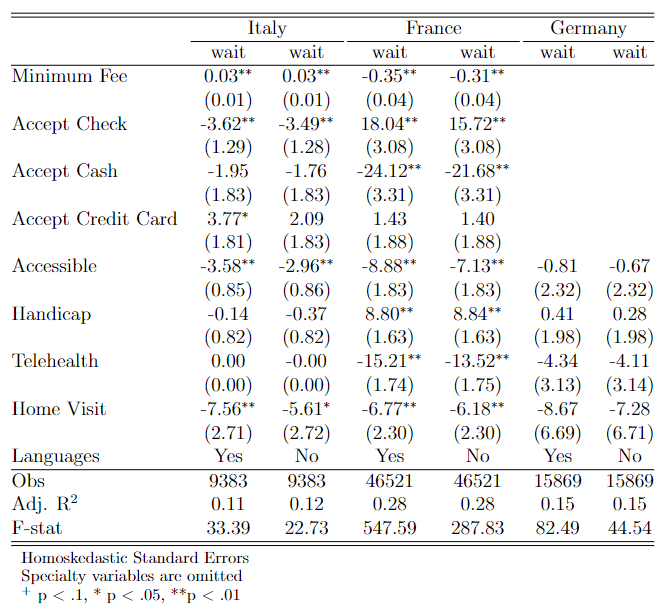

In [ ]:
# Regression for Minimum Fee

print(summary_col([model3, model4, model7, model8],
 model_names=['Italy No Languages','Italy All Variables','France No Languages','France All Variables'],
stars=True,
drop_omitted=True,
regressor_order=['wait', 'accept_check[T.True]','accept_cash[T.True]', 'accept_credit_card[T.True]','accessible[T.True]','handicap[T.True]', 'telehealth[T.True]', 'home_visit[T.True]']
))

pystout(models=[model3, model4, model7, model8],
 file='Table_2.tex',
 addnotes=['Homoskedastic Standard Errors','Specialty variables are omitted','\sym{+} p $<$ .1, * p $<$ .05, **p $<$ .01'],
 digits=2,
 title='Regression Table for Minimum Fee',
 exogvars=['wait', 'accept_check[T.True]','accept_cash[T.True]', 'accept_credit_card[T.True]','accessible[T.True]','handicap[T.True]', 'telehealth[T.True]', 'home_visit[T.True]'],
 endog_names=['fee','fee','fee','fee'],
 varlabels={'wait':'Waiting Time', 'accept_check[T.True]':'Accept Check','accept_cash[T.True]':'Accept Cash', 'accept_credit_card[T.True]':'Accept Credit Card','accessible[T.True]':'Accessible','handicap[T.True]':'Handicap', 'telehealth[T.True]':'Telehealth', 'home_visit[T.True]':'Home Visit'},
 addrows={'Languages':['Yes','No','Yes','No']},
 mgroups={'Italy':[1,2], 'France':[3,4]},
 modstat={'nobs':'Obs','rsquared_adj':'Adj. R\sym{2}','fvalue':'F-stat'}
 )


                           Italy No Languages Italy All Variables France No Languages France All Variables
----------------------------------------------------------------------------------------------------------
wait                       0.0348***          0.0354***           -0.0058***          -0.0051***          
                           (0.0115)           (0.0116)            (0.0006)            (0.0006)            
accept_check[T.True]       1.4053             1.4818              -1.6488***          -1.4671***          
                           (1.4339)           (1.4342)            (0.3948)            (0.3938)            
accept_cash[T.True]        -6.0411***         -6.3216***          2.3031***           2.0845***           
                           (2.0427)           (2.0419)            (0.4250)            (0.4239)            
accept_credit_card[T.True] 4.3980**           5.0176**            -1.4147***          -1.4148***          
                           (2.0201) 

/usr/local/lib/python3.8/dist-packages/pystout/pystout.py:368: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[str(v) for v in value]],index=[key],columns=df.columns))
/usr/local/lib/python3.8/dist-packages/pystout/pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))
/usr/local/lib/python3.8/dist-packages/pystout/pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))
/usr/local/lib/python3.8/dist-packages/pystout/pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optio

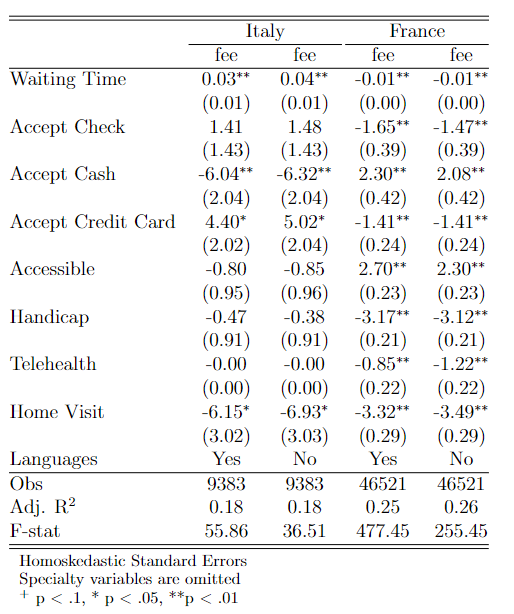

In [ ]:
# Regression for results of countries aggregated

print(summary_col([model13, model14, model15, model16],
 model_names=['Waiting time - No Languages','Waiting time - All Variables','Minimum Fee - No Languages','Minimum Fee - All Variables'],
stars=True,
drop_omitted=True,
regressor_order=['minimum_fee', 'wait','accept_check[T.True]','accept_cash[T.True]', 'accept_credit_card[T.True]','accessible[T.True]','handicap[T.True]', 'telehealth[T.True]', 'home_visit[T.True]']
))

pystout(models=[model13, model14, model15, model16],
 file='Table_3.tex',
 addnotes=['Homoskedastic Standard Errors','Specialty variables are omitted','\sym{+} p $<$ .1, * p $<$ .05, **p $<$ .01'],
 digits=2,
 title='Regression Table for aggregated countries',
 exogvars=['wait','minimum_fee', 'accept_check[T.True]','accept_cash[T.True]', 'accept_credit_card[T.True]','accessible[T.True]','handicap[T.True]', 'telehealth[T.True]', 'home_visit[T.True]'],
 endog_names=['Wait','Wait','Fee','Fee'],
 varlabels={'wait':'Waiting Time','minimum_fee':'Minimum Fee', 'accept_check[T.True]':'Accept Check','accept_cash[T.True]':'Accept Cash', 'accept_credit_card[T.True]':'Accept Credit Card','accessible[T.True]':'Accessible','handicap[T.True]':'Handicap', 'telehealth[T.True]':'Telehealth', 'home_visit[T.True]':'Home Visit'},
 addrows={'Languages':['Yes','No','Yes','No']},
#  mgroups={'Waiting Time':[1,2], 'Minimum Fee':[3,4]},
 modstat={'nobs':'Obs','rsquared_adj':'Adj. R\sym{2}','fvalue':'F-stat'}
 )


                           Waiting time - No Languages Waiting time - All Variables Minimum Fee - No Languages Minimum Fee - All Variables
------------------------------------------------------------------------------------------------------------------------------------------
minimum_fee                -0.1730***                  -0.1533***                                                                         
                           (0.0240)                    (0.0240)                                                                           
wait                                                                                -0.0054***                 -0.0048***                 
                                                                                    (0.0007)                   (0.0007)                   
accept_check[T.True]       7.2933***                   7.2916***                    -0.2698                    -0.3759                    
                          

/usr/local/lib/python3.8/dist-packages/pystout/pystout.py:368: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[str(v) for v in value]],index=[key],columns=df.columns))
/usr/local/lib/python3.8/dist-packages/pystout/pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))
/usr/local/lib/python3.8/dist-packages/pystout/pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))
/usr/local/lib/python3.8/dist-packages/pystout/pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optio

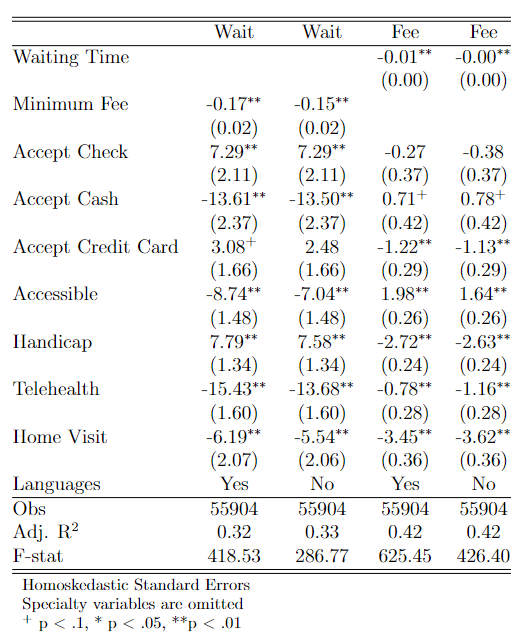

Analyzing the Regression Tables for the regression of Waiting Time and Minimum fee, we can observe that, for both cases, some variables are significant and present the expected behavior with the dependable variables. Nevertheless, the models themselves do not seem to make good predictions of them. And we can infer that the quality of the prediction is related to the number of samples collected as models with more data points performed better.

Even though most coefficients did not behave the expected way at the regressions and the models were not very successful in predicting the respective outcome, they presented some expected behaviors on the variable coefficients. Comparing the regressions for each country, France was the most successful and was the one that presented the more variable coefficients with the expected behavior. From the variables shown in both regression tables (all variables except the booleans for languages and specialization), we can observe that most are statistically significant, with p_values under 5% or 1%.

Variables such as "Minimum fee", "Telehealth" and "Home visit" mostly present an expected negative relation with the waiting time. These results confirm the expectations, because being willing to pay more or to have an appointment in a different way does not limit the appointments available and reduce the possible waiting time. In other words, a budget constraint or a rejection of specific appointment conditions would limit the set of possible doctors and increase waiting time. Moreover, "Waiting time", "Telehealth" and "Home visit", as expected, behave the same way, when predicting the minimum fee. 

Another expected behavior at the regressions’ result worth highlighting revolves around the payment methods variables. "Accept cash" in particular, is highly significant, has a high size, and has a negative relation with waiting time. As it is the most common payment method accepted in France, that form of payment does not contribute positively to the increase in waiting time. 

As for the other countries' regressions, we can consider their results to be impacted by the number of observations and lack of available data. For Italy, it is the country for which Doctolib has the least number of doctors subscribed and, therefore, results collected for most of the specialties.

In an attempt to analyze the impact of the number of observations, two new regressions for waiting time and minimum fee were computed with all the observations for different countries aggregated. As the results shown in the third table, disregarding all the details as we are only analyzing the impact of a larger number of observations, the regression performed better, keeping the tendency observed from Italy, Germany, and France to Aggregated.

As for Germany, not only it contains a small number of observations, but also its data for the minimum fee and payment methods are not available on the site. It can be explained by the characteristics of the German health system: as patients do not pay at the point of service and doctors receive payments directly from “sickness funds”, physicians have no reason to include this kind of data.


## References

[1] Complementary Medicine in Europe, P. Fisher and A. Ward, 1994. [Link available](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2540528/pdf/bmj00448-0043.pdf)

[2] Comment la mutuelle rembourse-t-elle les médecines douces ?, AG2R La Mondiale, 2023. [Link available](https://www.ag2rlamondiale.fr/sante-prevoyance/mutuelle-sante/conseil-medecines-douces-et-mutuelle-sante-quel-remboursement#:~:text=Pour%20compl%C3%A9ter%20la%20prise%20en,rembours%C3%A9s%20par%20la%20S%C3%A9curit%C3%A9%20sociale.)

[3] Population on 1 January by age group, sex and citizenship.[Link available](https://data.europa.eu/data/datasets/dycibsvr4z283jjduwvdaq?locale=en) 

[4] Ausländische Bevölkerung - Fachserie 1 Reihe 2 - 2021 [Link available](https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Migration-Integration/Publikationen/Downloads-Migration/auslaend-bevoelkerung-2010200217005.html)

[5] Les immigrés récemment arrivés en France - Une immigration de plus en plus européenne. [Link available](https://www.insee.fr/fr/statistiques/1281393)